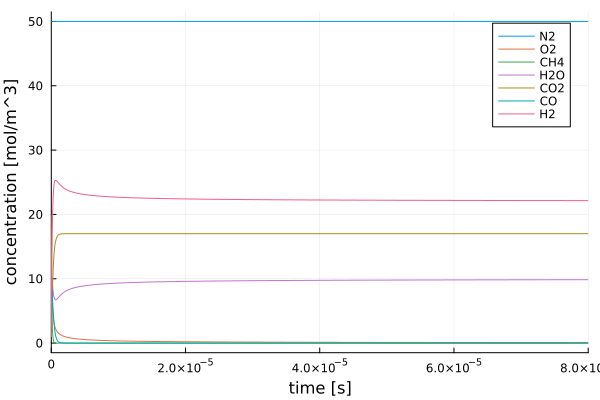

In [22]:
using DifferentialEquations
using Plots
using LinearAlgebra

# Temperature (assumed constant)
T = 1200 # K

# Initial species concentrations: N2, O2, CH4, H2O, CO2, CO, H2
X0 = [50.0, 20.0, 15.0, 1.0, 1.0, 1.0, 1.0] # mol/m^3

# Stoichiometric matrix
S = [0 -0.5 -1 0 0 1 2; 
     0 0 -1 -1 0 1 3; 
     0 -0.5 0 1 0 0 -1; 
     0 0.5 0 -1 0 0 1; 
     0 0 0 -1 1 -1 1; 
     0 0 0 1 -1 1 -1]

# Reaction rate function
function Arrhenius(T, X)
    R = 1.987204258640
    k  = zeros(6)
    k[1] = 0.44e12 * exp(-30000 / (R * T))
    k[2] = 0.30e9 * exp(-30000 / (R * T))
    k[3] = 0.25e17 * T^-1 * exp(-40000 / (R * T))
    k[4] = 0
    k[5] = 0.275e10 * exp(-20000 / (R * T))
    k[6] = 0

    # Ensure non-negative concentrations
    Y = max.(X, 1e-10)  # Avoid zero or negative concentrations for stability

    # Reaction rates
    r = zeros(6)
    r[1] = k[1] * Y[3]^0.5 * Y[2]^1.25
    r[2] = k[2] * Y[3] * Y[4]
    r[3] = k[3] * Y[7]^0.5 * Y[2]^2.25 * Y[4]^-1
    r[4] = 0
    r[5] = k[5] * Y[6] * Y[4]
    r[6] = 0

    return r
end

# Differential equations function
function f!(dX, X, p, t)
    r = Arrhenius(T, X)
    dX .= S'*r
end

# Define time span
tend = 8e-5
tspan = (0.0, tend)

# Define ODE problem
problem = ODEProblem(f!, X0, tspan)

# Solve ODE problem with a stiff solver and tighter tolerances
sol = solve(problem, alg_hints=[:stiff], reltol=1e-8, abstol=1e-10)

# Plot solution
plot1 = plot(sol, xlabel = "time [s]", ylabel = "concentration [mol/m^3]", label = ["N2" "O2" "CH4" "H2O" "CO2" "CO" "H2"])
plot(plot1, legend = true)
